In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Creation

In [ ]:
# root = "/content/drive/My Drive/Verisetleri"
# train_data = "train_data.txt"
# df = pd.read_csv(f"{root}/{train_data}",sep=':::',engine='python', header = None) #csv'nin ilk satırında sütun isimleri yazmıyorsa header = None vermek gerekiyor

In [ ]:
# df.columns = ['id','title','genre','description']

In [ ]:
# df.title = df.title.apply(lambda x: x[1: -1])
# df.genre = df.genre.apply(lambda x: x[1: -1])
# df.description = df.description.apply(lambda x: x[1:])

In [ ]:
# plt.style.use('fivethirtyeight')
# plt.figure(figsize = (12, 5))
# sns.countplot(x = df['genre']) # Count of number of descriptions for each class label
# plt.xticks(rotation = 60)
# plt.show()

In [ ]:
# comedy = df[df["genre"] == "comedy"].sample(50)
# horror = df[df["genre"] == "horror"].sample(50)
# sport = df[df["genre"] == "sport"].sample(50)
# animation = df[df["genre"] == "animation"].sample(50)
# drama = df[df["genre"] == "drama"].sample(50)
# scifi = df[df["genre"] == "sci-fi"].sample(50)
# documentary = df[df["genre"] == "documentary"].sample(50)
# music = df[df["genre"] == "music"].sample(50)
# crime = df[df["genre"] == "crime"].sample(50)
# family = df[df["genre"] == "family"].sample(50)

In [ ]:
# pd.concat([comedy, horror]).reset_index().drop(["index", "id", "title"], axis = 1).to_csv(f"{root}/mini_datasets/comedy_horror.csv", index = False)
# pd.concat([sport, animation]).reset_index().drop(["index", "id", "title"], axis = 1).to_csv(f"{root}/mini_datasets/sport_animation.csv", index = False)
# pd.concat([drama, scifi]).reset_index().drop(["index", "id", "title"], axis = 1).to_csv(f"{root}/mini_datasets/drama_scifi.csv", index = False)
# pd.concat([documentary, music]).reset_index().drop(["index", "id", "title"], axis = 1).to_csv(f"{root}/mini_datasets/documentary_music.csv", index = False)
# pd.concat([crime, family]).reset_index().drop(["index", "id", "title"], axis = 1).to_csv(f"{root}/mini_datasets/crime_family.csv", index = False)

# Classification

In [ ]:
def preprocess(text):
    # Metni küçük harfe dönüştürün ve noktalama işaretlerini kaldırın.
    text = text.lower()
    return ''.join(c for c in text if c not in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [ ]:
def create_random_individual(all_words, n_genes):
    individual = set()

    while len(individual) < n_genes:
        individual.add(random.choice(all_words))
    
    return list(individual)

In [ ]:
def create_initial_population(all_words, size, n_genes):
    return [create_random_individual(all_words, n_genes) for _ in range(size)]

In [ ]:
def fitness_function(individual, data):
    correct_predictions = 0
    classes = data['genre'].unique()
    label_to_id = {x: i for i, x in enumerate(classes)}

    for _, row in data.iterrows():
        text, label = row['description'], row['genre']
        words_in_text = set(text.split())

        words_in_individual = set(individual[:len(individual)//2])  # 1. sınıfa ait kelimeler
        score1 = len(words_in_text.intersection(words_in_individual))
        
        words_in_individual = set(individual[len(individual)//2:])  # 2. sınıfa ait kelimeler
        score2 = len(words_in_text.intersection(words_in_individual))
        
        predicted_label = 0 if score1 > score2 else 1 if score2 > score1 else random.choice([0, 1])
        
        if predicted_label == label_to_id[label]:
            correct_predictions += 1

    return correct_predictions / len(data)

In [ ]:
def selection(population, n_best, data):
    population.sort(key = lambda x: fitness_function(x, data), reverse = True)
    return population[:n_best]

In [ ]:
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

In [ ]:
def mutate(all_words, individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            word = random.choice(all_words)

            while word in individual:
                word = random.choice(all_words)
                
            individual[i] = word

    return individual

In [99]:
def create_new_generation(all_words, population, mutation_rate, data):
    n_best = len(population) // 2
    new_population = selection(population, n_best, data)
    
    parents = new_population[:]
    while len(new_population) < len(population):
        parent1 = parents.pop(random.randint(0, len(parents) - 1))
        parent2 = parents.pop(random.randint(0, len(parents) - 1))
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(all_words, child1, mutation_rate), mutate(all_words, child2, mutation_rate)])

    return new_population

In [100]:
def genetic_algorithm(data, all_words, population_size, n_genes, mutation_rate, n_generations):
    population = create_initial_population(all_words, population_size, n_genes)
    scores = []
    for _ in range(n_generations):
        population = create_new_generation(all_words, population, mutation_rate, data)
        
        best_individual = max(population, key = lambda x: fitness_function(x, data))
        best_score = fitness_function(best_individual, data)

        scores.append(best_score)

    return best_individual, best_score, scores

In [ ]:
root = "/content/drive/MyDrive/Verisetleri/mini_datasets"
dataset_names = ["comedy_horror", "sport_animation", "drama_scifi", "documentary_music", "crime_family"]
n_genes_list = [10, 50, 100]
population_size_list = [100, 200, 300]
mutation_rate = 0.1
n_generations = 300
start_idx, end_idx = 3, 4

In [ ]:
results = {dataset_name: {n_genes: {population_size: 0 for population_size in population_size_list} for n_genes in n_genes_list} for dataset_name in dataset_names[start_idx: end_idx]}
for dataset_name in dataset_names[start_idx: end_idx]:
    df = pd.read_csv(f"{root}/{dataset_name}.csv")
    df['description'] = df['description'].apply(preprocess)
    all_words = list(set(' '.join(df['description']).split()))
    for n_genes in n_genes_list:
        for population_size in population_size_list:
            best_individual, best_score = genetic_algorithm(df, all_words, population_size, n_genes, mutation_rate, n_generations)
            results[dataset_name][n_genes][population_size] = {"individual": best_individual, "score": best_score}
            print(f"{dataset_name} dataset, {n_genes} genes, {population_size} population size finished!")

documentary_music dataset, 10 genes, 100 population size finished!
documentary_music dataset, 10 genes, 200 population size finished!
documentary_music dataset, 10 genes, 300 population size finished!
documentary_music dataset, 50 genes, 100 population size finished!
documentary_music dataset, 50 genes, 200 population size finished!
documentary_music dataset, 50 genes, 300 population size finished!
documentary_music dataset, 100 genes, 100 population size finished!
documentary_music dataset, 100 genes, 200 population size finished!
documentary_music dataset, 100 genes, 300 population size finished!


In [ ]:
with open(f"{root}/{dataset_names[start_idx]}_results.json", "w", encoding = "utf-8") as result_file:
    json.dump(results, result_file)

In [ ]:
df1 = pd.read_json(f"{root}/comedy_horror_results.json")

In [ ]:
df1

In [ ]:
f = open(f"{root}/comedy_horror_results.json")

data1 = json.load(f)

In [ ]:
data1['comedy_horror']['100']

In [ ]:
df_comedy_horror = pd.DataFrame(data1['comedy_horror']).applymap(lambda x: x['score'])

In [ ]:
data1['comedy_horror']['100']['300']['individual']

In [ ]:
df_comedy_horror

,10,50,100
100,0.66,0.94,0.92
200,0.77,0.95,0.93
300,0.77,0.93,0.93


<Figure size 640x480 with 0 Axes>

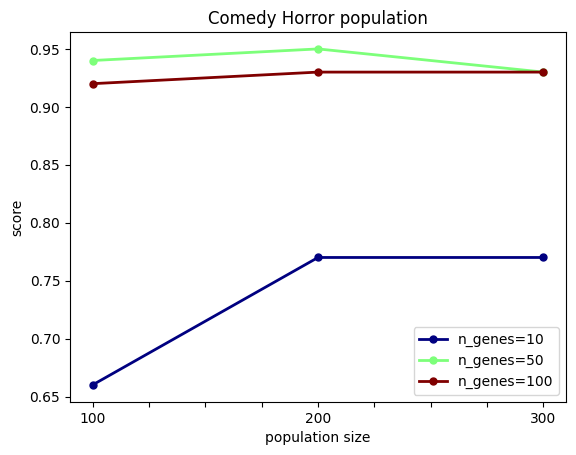

In [ ]:
plt.figure()
df_comedy_horror.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Comedy Horror population')
plt.xlabel('population size')
plt.ylabel('score')
plt.legend(["n_genes=10", "n_genes=50", "n_genes=100"])
plt.show()


In [ ]:
f1 = open(f"{root}/crime_family_results.json")

data2 = json.load(f1)

In [ ]:
df_crime_family = pd.DataFrame(data2['crime_family']).applymap(lambda x: x['score'])

In [ ]:
data2['crime_family']['100']['300']['individual']

In [ ]:
df_crime_family

,10,50,100
100,0.77,0.91,0.91
200,0.79,0.96,0.99
300,0.75,0.97,0.99


In [ ]:
data2['crime_family']['100']['300']['individual']

<Figure size 640x480 with 0 Axes>

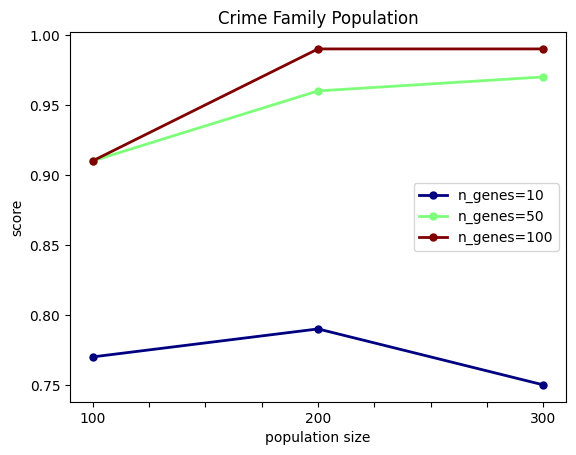

In [ ]:
plt.figure()
df_crime_family.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Crime Family Population')
plt.xlabel('population size')
plt.ylabel('score')
plt.legend(["n_genes=10", "n_genes=50", "n_genes=100"])
plt.show()


In [ ]:
f2 = open(f"{root}/documentary_music_results.json")

data3 = json.load(f2)

In [ ]:
df_documentary_music = pd.DataFrame(data3['documentary_music']).applymap(lambda x: x['score'])

In [ ]:
data3['documentary_music']['50']['300']['individual']

In [ ]:
df_documentary_music

,10,50,100
100,0.75,0.91,0.98
200,0.82,0.94,0.98
300,0.79,0.98,0.96


<Figure size 640x480 with 0 Axes>

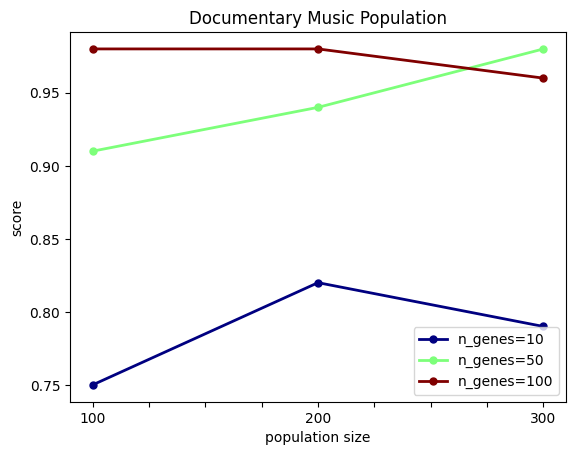

In [ ]:
plt.figure()
df_documentary_music.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Documentary Music Population')
plt.xlabel('population size')
plt.ylabel('score')
plt.legend(["n_genes=10", "n_genes=50", "n_genes=100"])
plt.show()

In [ ]:
f3 = open(f"{root}/drama_scifi_results.json")

data4 = json.load(f3)

In [ ]:
df_drama_scifi = pd.DataFrame(data4['drama_scifi']).applymap(lambda x: x['score'])

In [ ]:
df_drama_scifi

,10,50,100
100,0.73,0.90,0.95
200,0.77,0.96,0.95
300,0.79,0.97,0.94


In [ ]:
data4['drama_scifi']['50']['300']['individual']

<Figure size 640x480 with 0 Axes>

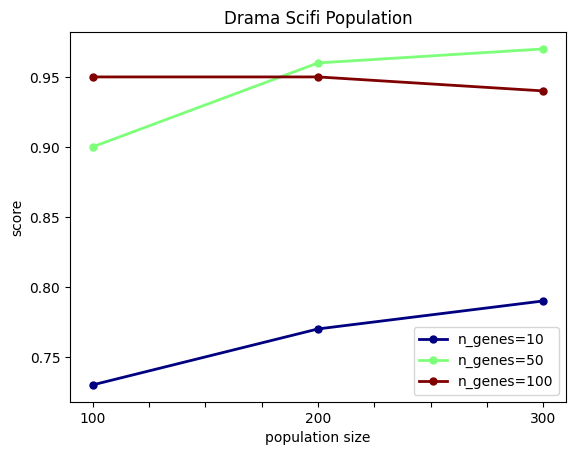

In [ ]:
plt.figure()
df_drama_scifi.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Drama Scifi Population')
plt.xlabel('population size')
plt.ylabel('score')
plt.legend(["n_genes=10", "n_genes=50", "n_genes=100"])
plt.show()

In [ ]:
f4 = open(f"{root}/sport_animation_results.json")

data5 = json.load(f4)

In [ ]:
df_sport_animation = pd.DataFrame(data5['sport_animation']).applymap(lambda x: x['score'])

In [ ]:
df_sport_animation

,10,50,100
100,0.76,0.95,0.93
200,0.75,0.94,0.94
300,0.84,0.96,0.98


In [ ]:
data5['sport_animation']['100']['300']['individual']

<Figure size 640x480 with 0 Axes>

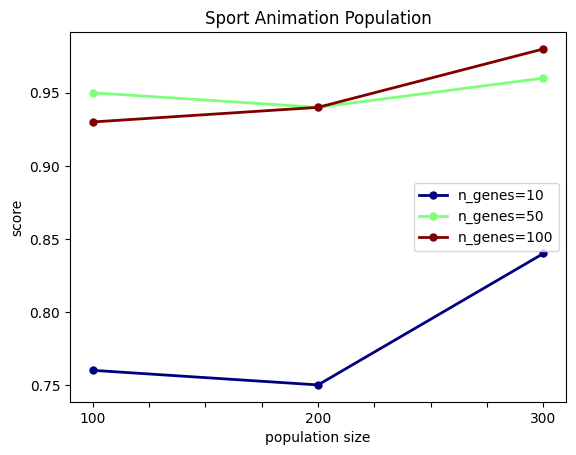

In [84]:
plt.figure()
df_sport_animation.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Sport Animation Population')
plt.xlabel('population size')
plt.ylabel('score')
plt.legend(["n_genes=10", "n_genes=50", "n_genes=100"])
plt.show()

In [85]:
dataset_name = "comedy_horror" # "sport_animation", "drama_scifi", "documentary_music", "crime_family"
n_genes = 10
population_size = 100
mutation_rate = 0.1
n_generations = 30

In [102]:
df = pd.read_csv(f"{root}/{dataset_name}.csv")
df['description'] = df['description'].apply(preprocess)
all_words = list(set(' '.join(df['description']).split()))

_,_,scores = genetic_algorithm(df, all_words, population_size, n_genes, mutation_rate, n_generations)

In [ ]:
scores

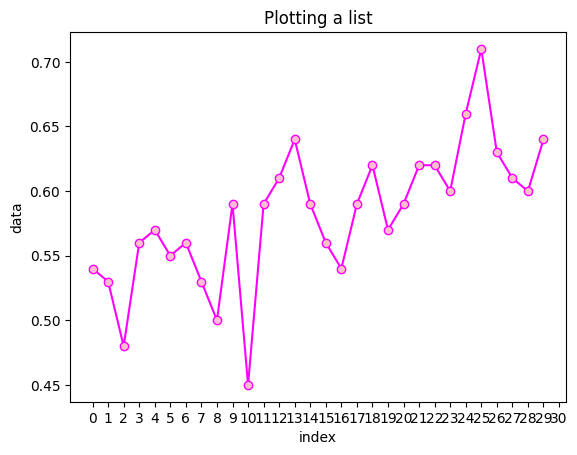

In [104]:
plt.plot(scores, color='magenta', marker='o',mfc='pink' ) #plot the data
plt.xticks(range(0,len(scores)+1, 1)) #set the tick frequency on x-axis

plt.ylabel('data') #set the label for y axis
plt.xlabel('index') #set the label for x-axis
plt.title("Plotting a list") #set the title of the graph
plt.show() #display the graph